### Практическая работа № 2

1. Самостоятельно разобраться с тем, что такое tfidf (документация https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html и еще - https://scikit-learn.org/stable/modules/feature_extraction.html#text-feature-extraction)
2. Модифицировать код функции get_user_embedding таким образом, чтобы считалось не среднее (как в примере np.mean), а медиана. Применить такое преобразование к данным, обучить модель прогнозирования оттока и посчитать метрики качества и сохранить их: roc auc, precision/recall/f_score (для 3 последних - подобрать оптимальный порог с помощью precision_recall_curve, как это делалось на уроке)
3. Повторить п.2, но используя уже не медиану, а max
4. (опциональное, если очень хочется) Воспользовавшись полученными знаниями из п.1, повторить пункт 2, но уже взвешивая новости по tfidf (подсказка: нужно получить веса-коэффициенты для каждого документа. Не все документы одинаково информативны и несут какой-то положительный сигнал). Подсказка 2 - нужен именно idf, как вес.
5. Сформировать на выходе единую таблицу, сравнивающую качество 3 разных метода получения эмбедингов пользователей: mean, median, max, idf_mean по метрикам roc_auc, precision, recall, f_score
6. Сделать самостоятельные выводы и предположения о том, почему тот или ной способ оказался эффективнее остальных

In [1]:
import pandas as pd

In [2]:
news = pd.read_csv("articles.csv")
print(news.shape)
news.head(3)

(27000, 2)


,doc_id,title
0,6,Заместитель председателяnправительства РФnСерг...
1,4896,Матч 1/16 финала Кубка России по футболу был п...
2,4897,Форвард «Авангарда» Томаш Заборский прокоммент...


In [3]:
users = pd.read_csv("users_articles.csv")
users.head(3)

,uid,articles
0,u105138,"[293672, 293328, 293001, 293622, 293126, 1852]"
1,u108690,"[3405, 1739, 2972, 1158, 1599, 322665]"
2,u108339,"[1845, 2009, 2356, 1424, 2939, 323389]"


In [4]:
#from gensim.test.utils import common_texts
from gensim.corpora.dictionary import Dictionary

In [5]:
#предобработка текстов
import re
import numpy as np
from nltk.corpus import stopwords
#from nltk.tokenize import word_tokenize

from razdel import tokenize # https://github.com/natasha/razdel
#!pip install razdel

import pymorphy2

In [6]:
stopword_ru = stopwords.words('russian')
len(stopword_ru)

morph = pymorphy2.MorphAnalyzer()

In [7]:
with open('stopwords.txt') as f:
    additional_stopwords = [w.strip() for w in f.readlines() if w]
stopword_ru += additional_stopwords
len(stopword_ru)

776

In [8]:
def clean_text(text):
    '''
    очистка текста
    
    на выходе очищеный текст
    
    '''
    if not isinstance(text, str):
        text = str(text)
    
    text = text.lower()
    text = text.strip('\n').strip('\r').strip('\t')
    text = re.sub("-\s\r\n\|-\s\r\n|\r\n", '', str(text))

    text = re.sub("[0-9]|[-—.,:;_%©«»?*!@#№$^•·&()]|[+=]|[[]|[]]|[/]|", '', text)
    text = re.sub(r"\r\n\t|\n|\\s|\r\t|\\n", ' ', text)
    text = re.sub(r'[\xad]|[\s+]', ' ', text.strip())
    
    #tokens = list(tokenize(text))
    #words = [_.text for _ in tokens]
    #words = [w for w in words if w not in stopword_ru]
    
    #return " ".join(words)
    return text

cache = {}

def lemmatization(text):
    '''
    лемматизация
        [0] если зашел тип не `str` делаем его `str`
        [1] токенизация предложения через razdel
        [2] проверка есть ли в начале слова '-'
        [3] проверка токена с одного символа
        [4] проверка есть ли данное слово в кэше
        [5] лемматизация слова
        [6] проверка на стоп-слова

    на выходе лист отлемматизированых токенов
    '''

    # [0]
    if not isinstance(text, str):
        text = str(text)
    
    # [1]
    tokens = list(tokenize(text))
    words = [_.text for _ in tokens]

    words_lem = []
    for w in words:
        if w[0] == '-': # [2]
            w = w[1:]
        if len(w)>1: # [3]
            if w in cache: # [4]
                words_lem.append(cache[w])
            else: # [5]
                temp_cach = cache[w] = morph.parse(w)[0].normal_form
                words_lem.append(temp_cach)
    
    words_lem_without_stopwords=[i for i in words_lem if not i in stopword_ru] # [6]
    
    return words_lem_without_stopwords

In [9]:
%%time
#Запускаем очистку текста. Будет долго...
news['title'] = news['title'].apply(lambda x: clean_text(x), 1)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:15: FutureWarning: Possible nested set at position 39
  from ipykernel import kernelapp as app


Wall time: 33.9 s


In [10]:
%%time
#Запускаем лемматизацию текста. Будет очень долго...
news['title'] = news['title'].apply(lambda x: lemmatization(x), 1)

Wall time: 4min 26s


In [11]:
#сформируем список наших текстов, разбив еще и на пробелы
texts = [t for t in news['title'].values]

# Create a corpus from a list of texts
common_dictionary = Dictionary(texts)
common_corpus = [common_dictionary.doc2bow(text) for text in texts]

In [12]:
common_dictionary[10]

'ватутин'

In [13]:
%%time
from gensim.models import LdaModel
# Train the model on the corpus.
lda = LdaModel(common_corpus, num_topics=25, id2word=common_dictionary)#, passes=10)

Wall time: 54.6 s


In [14]:
from gensim.test.utils import datapath
# Save model to disk.
temp_file = datapath("model.lda")
lda.save(temp_file)

# Load a potentially pretrained model from disk.
lda = LdaModel.load(temp_file)

C:\ProgramData\Anaconda3\lib\site-packages\smart_open\smart_open_lib.py:402: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL
C:\ProgramData\Anaconda3\lib\site-packages\smart_open\smart_open_lib.py:402: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL
C:\ProgramData\Anaconda3\lib\site-packages\smart_open\smart_open_lib.py:402: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-fu

In [15]:
# Create a new corpus, made of previously unseen documents.
other_texts = [t for t in news['title'].iloc[:3]]
other_corpus = [common_dictionary.doc2bow(text) for text in other_texts]

unseen_doc = other_corpus[2]
print(other_texts[2])
lda[unseen_doc] 

['форвард', 'авангард', 'томаш', 'заборский', 'прокомментировать', 'игра', 'свой', 'команда', 'матч', 'чемпионат', 'кхл', 'против', 'атланта', 'nnnn', 'провести', 'плохой', 'матч', 'нижний', 'новгород', 'против', 'торпедо', 'настраиваться', 'первый', 'минута', 'включиться', 'работа', 'сказать', 'заборский', 'получиться', 'забросить', 'быстрый', 'гол', 'задать', 'хороший', 'темп', 'поединок', 'мочь', 'играть', 'ещё', 'хороший', 'сторона', 'пять', 'очко', 'выезд', 'девять', 'это', 'хороший']


[(13, 0.062273163),
 (14, 0.24000028),
 (17, 0.24464014),
 (18, 0.41686988),
 (24, 0.018382126)]

In [16]:
x=lda.show_topics(num_topics=25, num_words=7,formatted=False)
topics_words = [(tp[0], [wd[0] for wd in tp[1]]) for tp in x]

#Below Code Prints Only Words 
for topic,words in topics_words:
    print("topic_{}: ".format(topic)+" ".join(words))

topic_0: год это который фонд человек новый экономика
topic_1: миссия договор палата флот обращение экипаж регистрация
topic_2: район пострадать турецкий кризис авария население сообщество
topic_3: военный сша ракета страна это год земля
topic_4: бизнесмен ii резерв пища знаменитый горизонт потенциально
topic_5: nn российский россия страна президент путин который
topic_6: это год который человек время россия мочь
topic_7: банк который научный наука год погибнуть nn
topic_8: тело статья иран ст след обнаружить километр
topic_9: лёд сближение развивающийся актуальный рисунок финляндия кит
topic_10: год цена тыс поверхность напомнить это ноябрь
topic_11: год это который первый компания научный рынок
topic_12: млн рубль год рост составить доллар остров
topic_13: газ сократиться место рейтинг nn золото высота
topic_14: офицер следствие год летний британский ремонт испанский
topic_15: год налог жизнь болезнь умереть врач больница
topic_16: это россия который год правительство москва глава
to

In [17]:
def get_lda_vector(text):
    unseen_doc = common_dictionary.doc2bow(text)
    lda_tuple = lda[unseen_doc]
    not_null_topics = dict(zip([i[0] for i in lda_tuple], [i[1] for i in lda_tuple]))

    output_vector = []
    for i in range(25):
        if i not in not_null_topics:
            output_vector.append(0)
        else:
            output_vector.append(not_null_topics[i])
    return np.array(output_vector)

In [18]:
topic_matrix = pd.DataFrame([get_lda_vector(text) for text in news['title'].values])
topic_matrix.columns = ['topic_{}'.format(i) for i in range(25)]
topic_matrix['doc_id'] = news['doc_id'].values
topic_matrix = topic_matrix[['doc_id']+['topic_{}'.format(i) for i in range(25)]]
topic_matrix.head(5)

,doc_id,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,...,topic_15,topic_16,topic_17,topic_18,topic_19,topic_20,topic_21,topic_22,topic_23,topic_24
0,6,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.124229,0.0,...,0.000000,0.781102,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000
1,4896,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,...,0.030608,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.714032,0.0,0.000000
2,4897,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,...,0.000000,0.000000,0.244594,0.416987,0.0,0.0,0.0,0.000000,0.0,0.018401
3,4898,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,...,0.000000,0.000000,0.000000,0.924426,0.0,0.0,0.0,0.000000,0.0,0.000000
4,4899,0.0,0.0,0.0,0.0,0.0,0.0,0.384158,0.000000,0.0,...,0.000000,0.264327,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000


In [19]:
users.head(3)

,uid,articles
0,u105138,"[293672, 293328, 293001, 293622, 293126, 1852]"
1,u108690,"[3405, 1739, 2972, 1158, 1599, 322665]"
2,u108339,"[1845, 2009, 2356, 1424, 2939, 323389]"


In [20]:
doc_dict = dict(zip(topic_matrix['doc_id'].values, topic_matrix[['topic_{}'.format(i) for i in range(25)]].values))

In [21]:
doc_dict[293622]

array([0.        , 0.        , 0.12270401, 0.        , 0.        ,
       0.19653341, 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.15067321, 0.        , 0.        , 0.        ,
       0.07680818, 0.        , 0.05072554, 0.        , 0.07738559,
       0.04981483, 0.        , 0.        , 0.26503167, 0.        ])

In [22]:
user_articles_list = users['articles'].iloc[33]

def get_user_embedding(user_articles_list):
    user_articles_list = eval(user_articles_list)
    user_vector = np.array([doc_dict[doc_id] for doc_id in user_articles_list])
    user_vector = np.mean(user_vector, 0)
    return user_vector

In [23]:
get_user_embedding(user_articles_list)

array([0.02810179, 0.00471029, 0.00945655, 0.07381781, 0.        ,
       0.1375926 , 0.13726887, 0.01561063, 0.        , 0.        ,
       0.01244011, 0.02407722, 0.        , 0.        , 0.01719686,
       0.01754944, 0.2300845 , 0.00616929, 0.12959482, 0.        ,
       0.01902038, 0.        , 0.00868202, 0.10889474, 0.00934994])

In [24]:
users['articles'].iloc[33]

'[323329, 321961, 324743, 323186, 324632, 474690]'

In [25]:
" ".join(news[news['doc_id']==323186]['title'].iloc[0])

'глава российский мид сергей лавров опровергнуть появиться сми информация якобы готовиться обмен декларация россия сша сотрудничество сфера сообщать риа новость nn читать сообщение разговаривать автор сообщение знать откуда автор источник какихлибо основание подобный род репортаж знать откуда информация появиться сказать журналист итог встреча госсекретарь сша джон керри nn позиция свой изложить декларация напринимать достаточно рамка обсе рамка совет россия нато высокий уровень продекларировать всё обеспечивать неделимость безопасность никто обеспечивать свой безопасность счёт безопасность продолжить министр слово лавров москва считать система нато создавать проблема наш безопасность поэтому декларация недостаточно мочь договариваться совместный система россия предлагать ещё начинать год президент путин посещать сша нужно вести речь очередной декларация гарантия который проверять объективный военнотехнический критерий гарантия ненаправленность система против российский ядерный потенци

In [26]:
user_embeddings = pd.DataFrame([i for i in users['articles'].apply(lambda x: get_user_embedding(x), 1)])
user_embeddings.columns = ['topic_{}'.format(i) for i in range(25)]
user_embeddings['uid'] = users['uid'].values
user_embeddings = user_embeddings[['uid']+['topic_{}'.format(i) for i in range(25)]]
user_embeddings.head(3)

,uid,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,...,topic_15,topic_16,topic_17,topic_18,topic_19,topic_20,topic_21,topic_22,topic_23,topic_24
0,u105138,0.037443,0.0,0.032707,0.011360,0.0,0.064237,0.126408,0.009489,0.00000,...,0.012801,0.099112,0.019918,0.061117,0.095515,0.104311,0.001798,0.038861,0.097186,0.056784
1,u108690,0.041350,0.0,0.025060,0.013547,0.0,0.106997,0.250589,0.050389,0.00000,...,0.019324,0.136576,0.000000,0.138148,0.012214,0.008999,0.012996,0.020237,0.066081,0.029750
2,u108339,0.044688,0.0,0.015083,0.049712,0.0,0.088886,0.246809,0.041201,0.00303,...,0.009782,0.099215,0.000000,0.070273,0.009304,0.049944,0.006440,0.088906,0.082226,0.003750


In [27]:
target = pd.read_csv("users_churn.csv")
target.head(3)

,uid,churn
0,u107120,0
1,u102277,0
2,u102444,0


In [28]:
X = pd.merge(user_embeddings, target, 'left')
X.head(3)

,uid,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,...,topic_16,topic_17,topic_18,topic_19,topic_20,topic_21,topic_22,topic_23,topic_24,churn
0,u105138,0.037443,0.0,0.032707,0.011360,0.0,0.064237,0.126408,0.009489,0.00000,...,0.099112,0.019918,0.061117,0.095515,0.104311,0.001798,0.038861,0.097186,0.056784,0
1,u108690,0.041350,0.0,0.025060,0.013547,0.0,0.106997,0.250589,0.050389,0.00000,...,0.136576,0.000000,0.138148,0.012214,0.008999,0.012996,0.020237,0.066081,0.029750,1
2,u108339,0.044688,0.0,0.015083,0.049712,0.0,0.088886,0.246809,0.041201,0.00303,...,0.099215,0.000000,0.070273,0.009304,0.049944,0.006440,0.088906,0.082226,0.003750,1


In [29]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
#import itertools

import matplotlib.pyplot as plt

%matplotlib inline

In [30]:
#разделим данные на train/test
X_train, X_test, y_train, y_test = train_test_split(X[['topic_{}'.format(i) for i in range(25)]], 
                                                    X['churn'], random_state=0)

In [31]:
logreg = LogisticRegression()
#обучим 
logreg.fit(X_train, y_train)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

In [32]:
#наши прогнозы для тестовой выборки
preds = logreg.predict_proba(X_test)[:, 1]
preds[:10]

array([0.0945554 , 0.03097448, 0.55270894, 0.2881504 , 0.02474828,
       0.06829457, 0.36797553, 0.04376713, 0.15246093, 0.33813332])

In [33]:
from sklearn.metrics import f1_score, roc_auc_score, precision_score, classification_report, precision_recall_curve, confusion_matrix

In [34]:
precision, recall, thresholds = precision_recall_curve(y_test, preds)
fscore = (2 * precision * recall) / (precision + recall)
# locate the index of the largest f score
ix = np.argmax(fscore)
print('Best Threshold=%f, F-Score=%.3f, Precision=%.3f, Recall=%.3f' % (thresholds[ix], 
                                                                        fscore[ix],
                                                                        precision[ix],
                                                                        recall[ix]))

Best Threshold=0.319752, F-Score=0.754, Precision=0.738, Recall=0.771


In [42]:
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization
[[1688   67]
 [  57  188]]


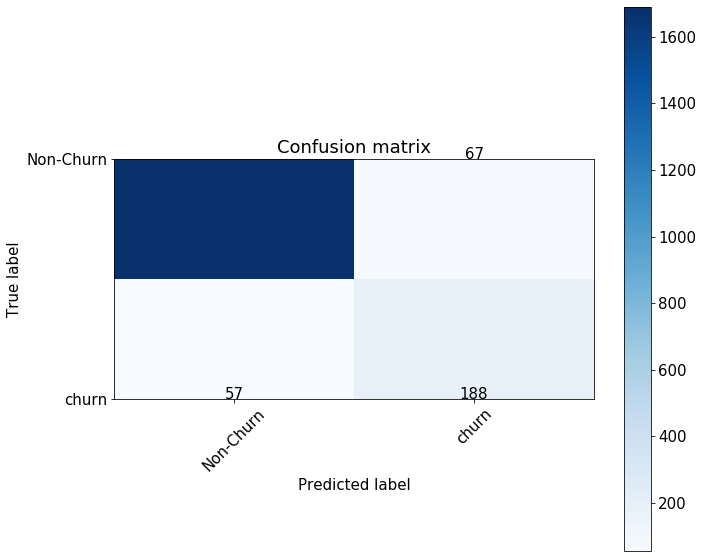

In [43]:
#мы уже нашли ранее "оптимальный" порог, когда максимизировали f_score
font = {'size' : 15}

plt.rc('font', **font)

cnf_matrix = confusion_matrix(y_test, preds>thresholds[ix])
plt.figure(figsize=(10, 8))
plot_confusion_matrix(cnf_matrix, classes=['Non-Churn', 'churn'],
                      title='Confusion matrix')
plt.savefig("conf_matrix.png")
plt.show()

In [37]:
roc_auc_score(y_test, preds)

0.9664538635967208

In [45]:
def get_user_embedding_median(user_articles_list):
    user_articles_list = eval(user_articles_list)
    user_vector = np.array([doc_dict[doc_id] for doc_id in user_articles_list])
    user_vector = np.median(user_vector, 0)
    return user_vector

In [46]:
get_user_embedding_median(user_articles_list)

array([0.        , 0.        , 0.        , 0.03812471, 0.        ,
       0.06482311, 0.09961277, 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.1752179 , 0.        , 0.10683517, 0.        ,
       0.        , 0.        , 0.        , 0.05754787, 0.        ])

In [47]:
user_embeddings = pd.DataFrame([i for i in users['articles'].apply(lambda x: get_user_embedding_median(x), 1)])
user_embeddings.columns = ['topic_{}'.format(i) for i in range(25)]
user_embeddings['uid'] = users['uid'].values
user_embeddings = user_embeddings[['uid']+['topic_{}'.format(i) for i in range(25)]]
user_embeddings.head(3)

,uid,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,...,topic_15,topic_16,topic_17,topic_18,topic_19,topic_20,topic_21,topic_22,topic_23,topic_24
0,u105138,0.017358,0.0,0.014886,0.000000,0.0,0.014220,0.068593,0.000000,0.0,...,0.000000,0.026562,0.0,0.000000,0.038693,0.066795,0.0,0.000000,0.013227,0.011527
1,u108690,0.027901,0.0,0.000000,0.000000,0.0,0.064814,0.222032,0.032643,0.0,...,0.013238,0.156838,0.0,0.102646,0.000000,0.006635,0.0,0.000000,0.029164,0.018649
2,u108339,0.035024,0.0,0.007086,0.015707,0.0,0.035646,0.250316,0.039423,0.0,...,0.000000,0.056658,0.0,0.027437,0.000000,0.027330,0.0,0.076377,0.058569,0.000000


In [48]:
X = pd.merge(user_embeddings, target, 'left')
X.head(3)

,uid,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,...,topic_16,topic_17,topic_18,topic_19,topic_20,topic_21,topic_22,topic_23,topic_24,churn
0,u105138,0.017358,0.0,0.014886,0.000000,0.0,0.014220,0.068593,0.000000,0.0,...,0.026562,0.0,0.000000,0.038693,0.066795,0.0,0.000000,0.013227,0.011527,0
1,u108690,0.027901,0.0,0.000000,0.000000,0.0,0.064814,0.222032,0.032643,0.0,...,0.156838,0.0,0.102646,0.000000,0.006635,0.0,0.000000,0.029164,0.018649,1
2,u108339,0.035024,0.0,0.007086,0.015707,0.0,0.035646,0.250316,0.039423,0.0,...,0.056658,0.0,0.027437,0.000000,0.027330,0.0,0.076377,0.058569,0.000000,1


In [49]:
#разделим данные на train/test
X_train, X_test, y_train, y_test = train_test_split(X[['topic_{}'.format(i) for i in range(25)]], 
                                                    X['churn'], random_state=0)

In [50]:
logreg = LogisticRegression()
#обучим 
logreg.fit(X_train, y_train)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

In [51]:
#наши прогнозы для тестовой выборки
preds = logreg.predict_proba(X_test)[:, 1]
preds[:10]

array([0.15262524, 0.03335715, 0.40552068, 0.41793247, 0.03358956,
       0.06116044, 0.37488187, 0.07587715, 0.14254289, 0.21657257])

In [52]:
precision, recall, thresholds = precision_recall_curve(y_test, preds)
fscore = (2 * precision * recall) / (precision + recall)
# locate the index of the largest f score
ix = np.argmax(fscore)
print('Best Threshold=%f, F-Score=%.3f, Precision=%.3f, Recall=%.3f' % (thresholds[ix], 
                                                                        fscore[ix],
                                                                        precision[ix],
                                                                        recall[ix]))

Best Threshold=0.308691, F-Score=0.768, Precision=0.735, Recall=0.804


In [53]:
roc_auc_score(y_test, preds)

0.9741333798476656

Confusion matrix, without normalization
[[1684   71]
 [  49  196]]


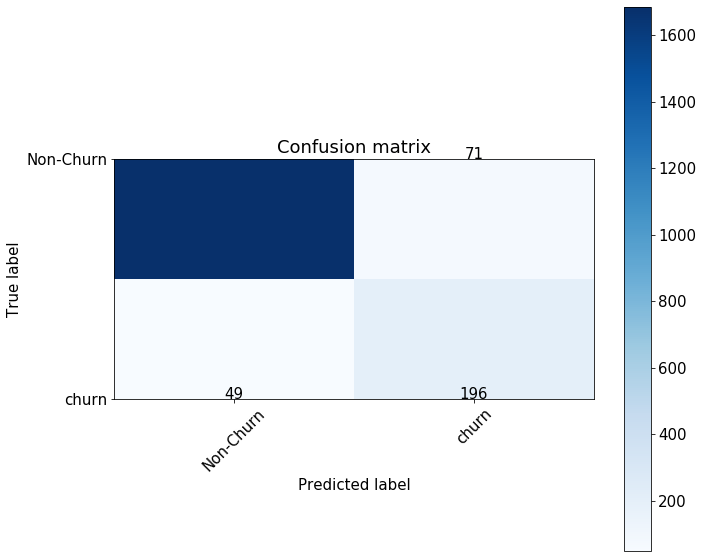

In [54]:
#мы уже нашли ранее "оптимальный" порог, когда максимизировали f_score
font = {'size' : 15}

plt.rc('font', **font)

cnf_matrix = confusion_matrix(y_test, preds>thresholds[ix])
plt.figure(figsize=(10, 8))
plot_confusion_matrix(cnf_matrix, classes=['Non-Churn', 'churn'],
                      title='Confusion matrix')
plt.savefig("conf_matrix.png")
plt.show()

In [55]:
def get_user_embedding_max(user_articles_list):
    user_articles_list = eval(user_articles_list)
    user_vector = np.array([doc_dict[doc_id] for doc_id in user_articles_list])
    user_vector = np.max(user_vector, 0)
    return user_vector

In [56]:
get_user_embedding_max(user_articles_list)

array([0.16861072, 0.02826177, 0.05673928, 0.2353242 , 0.        ,
       0.49826208, 0.37284541, 0.06901215, 0.        , 0.        ,
       0.05471834, 0.12476582, 0.        , 0.        , 0.09050827,
       0.10529661, 0.49916571, 0.03701572, 0.3602688 , 0.        ,
       0.11412228, 0.        , 0.03865521, 0.38029516, 0.05609966])

In [57]:
user_embeddings = pd.DataFrame([i for i in users['articles'].apply(lambda x: get_user_embedding_max(x), 1)])
user_embeddings.columns = ['topic_{}'.format(i) for i in range(25)]
user_embeddings['uid'] = users['uid'].values
user_embeddings = user_embeddings[['uid']+['topic_{}'.format(i) for i in range(25)]]
user_embeddings.head(3)

,uid,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,...,topic_15,topic_16,topic_17,topic_18,topic_19,topic_20,topic_21,topic_22,topic_23,topic_24
0,u105138,0.131127,0.0,0.122704,0.046394,0.0,0.196533,0.321093,0.056935,0.00000,...,0.076808,0.390350,0.068784,0.315408,0.384446,0.319913,0.010787,0.233164,0.291628,0.245358
1,u108690,0.127836,0.0,0.117502,0.056583,0.0,0.339174,0.436117,0.141154,0.00000,...,0.046070,0.173363,0.000000,0.333605,0.039364,0.026462,0.053876,0.063042,0.184445,0.080025
2,u108339,0.133275,0.0,0.039091,0.194652,0.0,0.314407,0.324129,0.088271,0.01818,...,0.030325,0.259685,0.000000,0.324308,0.044245,0.173625,0.038640,0.212346,0.190740,0.022501


In [58]:
X = pd.merge(user_embeddings, target, 'left')
X.head(3)

,uid,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,...,topic_16,topic_17,topic_18,topic_19,topic_20,topic_21,topic_22,topic_23,topic_24,churn
0,u105138,0.131127,0.0,0.122704,0.046394,0.0,0.196533,0.321093,0.056935,0.00000,...,0.390350,0.068784,0.315408,0.384446,0.319913,0.010787,0.233164,0.291628,0.245358,0
1,u108690,0.127836,0.0,0.117502,0.056583,0.0,0.339174,0.436117,0.141154,0.00000,...,0.173363,0.000000,0.333605,0.039364,0.026462,0.053876,0.063042,0.184445,0.080025,1
2,u108339,0.133275,0.0,0.039091,0.194652,0.0,0.314407,0.324129,0.088271,0.01818,...,0.259685,0.000000,0.324308,0.044245,0.173625,0.038640,0.212346,0.190740,0.022501,1


In [59]:
#разделим данные на train/test
X_train, X_test, y_train, y_test = train_test_split(X[['topic_{}'.format(i) for i in range(25)]], 
                                                    X['churn'], random_state=0)

In [60]:
logreg = LogisticRegression()
#обучим 
logreg.fit(X_train, y_train)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

In [61]:
#наши прогнозы для тестовой выборки
preds = logreg.predict_proba(X_test)[:, 1]
preds[:10]

array([0.08062569, 0.00262861, 0.88191638, 0.07777906, 0.0147146 ,
       0.09734842, 0.3464874 , 0.02462014, 0.01449783, 0.21248339])

In [62]:
precision, recall, thresholds = precision_recall_curve(y_test, preds)
fscore = (2 * precision * recall) / (precision + recall)
# locate the index of the largest f score
ix = np.argmax(fscore)
print('Best Threshold=%f, F-Score=%.3f, Precision=%.3f, Recall=%.3f' % (thresholds[ix], 
                                                                        fscore[ix],
                                                                        precision[ix],
                                                                        recall[ix]))

Best Threshold=0.397369, F-Score=0.818, Precision=0.838, Recall=0.800


In [63]:
roc_auc_score(y_test, preds)

0.9768079539508111

Confusion matrix, without normalization
[[1717   38]
 [  50  195]]


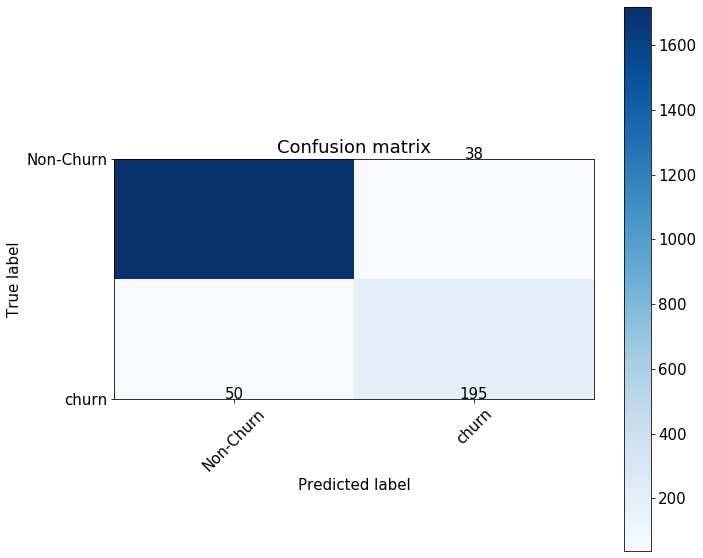

In [64]:
#мы уже нашли ранее "оптимальный" порог, когда максимизировали f_score
font = {'size' : 15}

plt.rc('font', **font)

cnf_matrix = confusion_matrix(y_test, preds>thresholds[ix])
plt.figure(figsize=(10, 8))
plot_confusion_matrix(cnf_matrix, classes=['Non-Churn', 'churn'],
                      title='Confusion matrix')
plt.savefig("conf_matrix.png")
plt.show()

In [82]:
from prettytable import PrettyTable

data = [['roc_auc',0.966,0.974,0.977],['precision',0.738,0.735,0.838],['recall',0.771,0.804,0.8],['f_score',0.754,0.768,0.818]]
df = pd.DataFrame(data, columns=['name', 'mean', 'median', 'max'])

def generate_ascii_table(df):
    x = PrettyTable()
    x.field_names = df.columns.tolist()
    for row in df.values:
        x.add_row(row)
    print(x)
    return x

generate_ascii_table(df)

+-----------+-------+--------+-------+
|    name   |  mean | median |  max  |
+-----------+-------+--------+-------+
|  roc_auc  | 0.966 | 0.974  | 0.977 |
| precision | 0.738 | 0.735  | 0.838 |
|   recall  | 0.771 | 0.804  |  0.8  |
|  f_score  | 0.754 | 0.768  | 0.818 |
+-----------+-------+--------+-------+
